In [3]:
# Input from wav file

import wave
import array

wf = wave.open('../data/Microwave finish (fan background).wav', 'rb')

data = wf.readframes(wf.getnframes())

input_framerate = wf.getframerate()
vals = array.array('H', data)


In [4]:
# Downsample to reduce data, based on max frequency

from scipy.signal import resample
from math import floor

max_capture_frequency = 5_000
min_capture_freqency = 50

target_framerate = max_capture_frequency * 2
target_samples = floor(len(vals) * target_framerate / input_framerate)

vals_ds = resample(vals, target_samples)

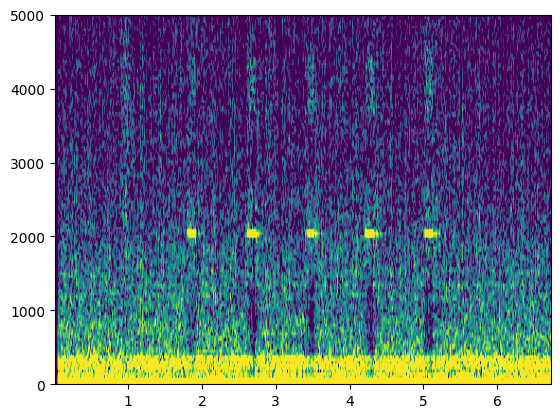

In [82]:
from matplotlib import pyplot as plt

_ = plt.specgram(vals_ds, Fs=target_framerate, vmin=40, vmax=60)

In [87]:
# Extract excerpt of interest

from math import floor

start_timestamp = 12.8
start_i_sample = floor(start_timestamp * target_framerate)

excerpt_duration = 7.0
excerpt_n_samples = floor(excerpt_duration * target_framerate)

excerpt_vals = vals_ds #vals_ds[start_i_sample:start_i_sample + excerpt_n_samples]

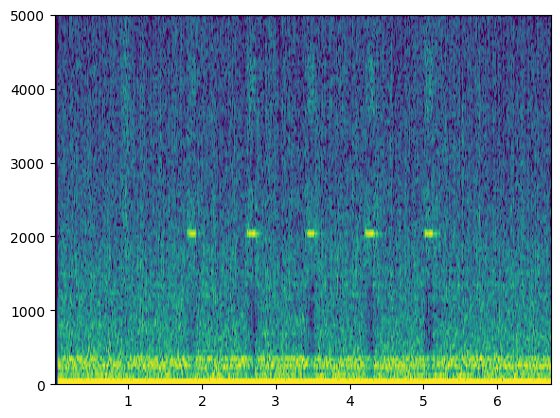

In [88]:
from matplotlib import pyplot as plt

_ = plt.specgram(excerpt_vals, Fs=target_framerate, vmin=30, vmax=70)

In [89]:
# Perform FFT on each chunk

from scipy.signal import spectrogram
import numpy as np

chunk_n_samples = 256 # Use power of two to maximise FFT performance
chunk_duration = chunk_n_samples / target_framerate

print(f"Chunk duration is {chunk_duration*1e3}ms")

f, t, chunks_spec = spectrogram(
  excerpt_vals,
  fs=target_framerate,
  nperseg=chunk_n_samples,
  noverlap=0
)

chunks_spec = 10*np.log10(chunks_spec)

Chunk duration is 25.6ms


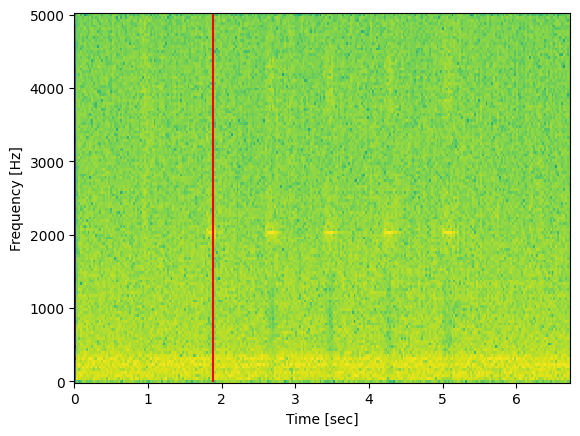

In [119]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

i_analyse = 73
t_analyse = t[i_analyse]

fig, ax = plt.subplots()

ax.pcolormesh(t, f, chunks_spec)
ax.add_line(Line2D([t_analyse, t_analyse], [0, 5000], color="#F00"))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.show()


In [123]:
from scipy.signal import find_peaks
import numpy as np

chunks_freqs = np.transpose(chunks_spec)
chunks_peaks = [find_peaks(chunk_freqs, prominence=20, distance=10) for chunk_freqs in chunks_freqs]

chunks_peak_analyse = chunks_peaks[i_analyse][0]

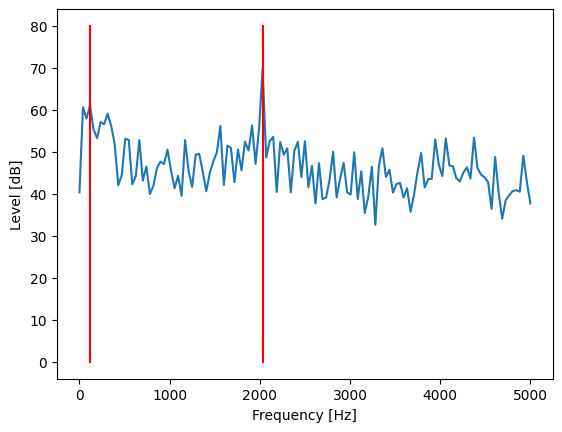

In [124]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

fig, ax = plt.subplots()

ax.plot(f, chunks_freqs[i_analyse], 10)
for peak in chunks_peak_analyse:
  peak_f = f[peak]
  ax.add_line(Line2D([peak_f, peak_f], [0, 80], color="#F00"))
plt.ylabel('Level [dB]')
plt.xlabel('Frequency [Hz]')

plt.show()

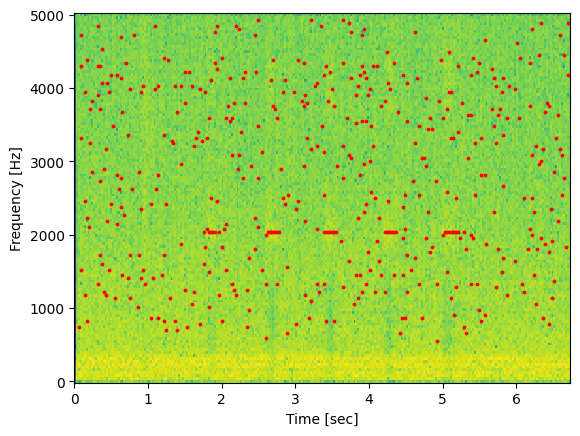

In [126]:


from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
import numpy as np

chunks_peaks_freqs = [[f[peak] for peak in chunk_peaks] for chunk_peaks, _ in chunks_peaks]

xs = []
ys = []
for i in range(len(chunks_peaks_freqs)):
  for p in chunks_peaks_freqs[i]:
    if p > 500:
      xs.append(t[i])
      ys.append(p)

fig, ax = plt.subplots()

ax.pcolormesh(t, f, chunks_spec)
ax.scatter(xs, ys, s=3, c="#F00")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.show()

In [39]:
fingerprint_microwave = [
  {
    'type': 'sine',
    'frequency': 2030,
    'start_ms': 0, # sample 65
    'end_ms': 250 # sample 74
  }
]

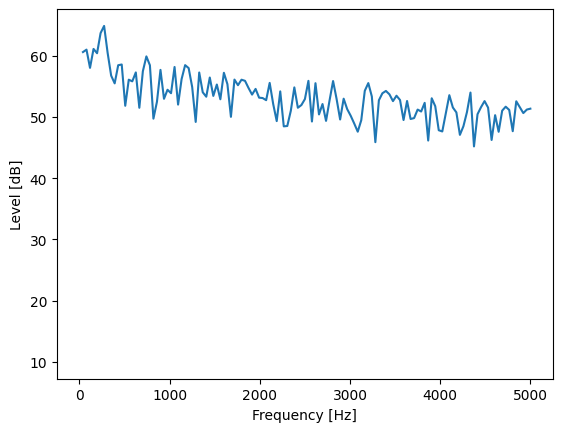

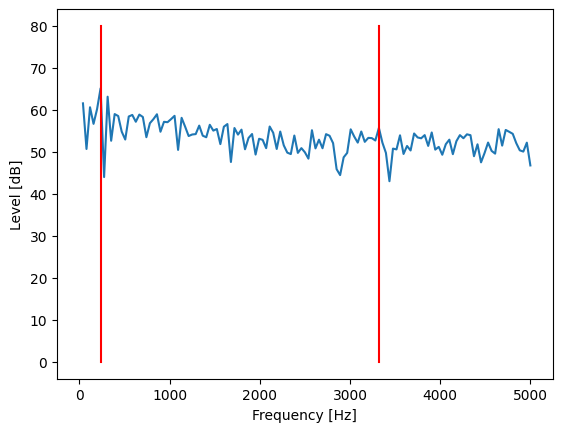

KeyboardInterrupt: 

In [67]:
import numpy as np
from scipy.fft import rfftfreq, rfft
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from matplotlib.lines import Line2D
import logging as log
from math import floor

PROMINENCE = 10 # Min prominence for detecting local peak
DISTANCE = 10 # Min distance of peak from adjacent peaks
CHUNK_LENGTH = 256
SAMPLE_RATE = 10000

MATCH_FREQUENCY_TOLERANCE = 0.03 # Tolerance of matching fingerprint frequency as multiple of frequency to match
MATCH_TIME_TOLERANCE = 1 # Tolerance of matching fingerprint timing in chunks

def ms_to_chunks(ms):
  return floor(ms * SAMPLE_RATE / 1000 / CHUNK_LENGTH)

fs = rfftfreq(CHUNK_LENGTH) * target_framerate # type: ignore
fs = fs[fs > 0]

fingerprints = {
  "microwave": [
    {
      'type': 'sine',
      'frequency': 2030,
      'start_chunk': ms_to_chunks(0), # sample 65
      'end_chunk': ms_to_chunks(250) # sample 74
    }
  ]
}

match_progress = { k: { 'stage': 0, 'chunk': 0 } for k in fingerprints.keys() } # type: ignore

def process_chunk(samples):
  if samples.size != CHUNK_LENGTH:
    log.warning(f"Received a chunk containing {samples.size} samples which does not match expected length of {CHUNK_LENGTH}")
  
  freq_vals = np.absolute(rfft(samples)[1:]) # type: ignore
  freq_db = 10*np.log10(freq_vals) # type: ignore

  freq_peaks_i = find_peaks(freq_db, prominence=PROMINENCE, distance=DISTANCE)[0]
  freq_peaks = [fs[peak] for peak in freq_peaks_i]

  ## Plot

  fig, ax = plt.subplots()

  ax.plot(fs, freq_db, 10)
  for peak in freq_peaks:
    ax.add_line(Line2D([peak, peak], [0, 80], color="#F00"))
  plt.ylabel('Level [dB]')
  plt.xlabel('Frequency [Hz]')

  plt.show()

  # Do matching

  for k, progress in match_progress.items():
    # Stage continues
    fingerprint = fingerprints[k]
    
    # The chunk we're looking for would come within the time limit
    stage = fingerprint[progress['stage']]
    is_match_t = progress['chunk'] <= stage['end_chunk'] + MATCH_TIME_TOLERANCE # type: ignore
    is_match_f = np.any(np.isclose(freq_peaks, stage['frequency'], rtol=MATCH_FREQUENCY_TOLERANCE)) # type: ignore

    if is_match_f and is_match_t:
      # Match for current stage -> progress within stage
      progress['chunk'] += 1
      break
    
    # It's a match for the next stage
    # Not a match but we're within tolerance for stage -> progress
    # Not a match and we've missed tolerance for stage
  


    
      
    

i_sample = 63 * CHUNK_LENGTH
while i_sample < len(vals_ds):
  process_chunk(vals_ds[i_sample:i_sample + CHUNK_LENGTH])
  i_sample += CHUNK_LENGTH